---
# Module 6.2 : Exemple de regroupement des données en analyse d'image
---

Dans ce script en Python, nous allons voir comment utiliser les méthodes de regroupement de données (*clustering*) pour réduire le nombre de couleurs dans une image.  

Nous allons utiliser l'image suivante d'un vol d'oies. Le nombre de couleurs est assez limité; combien en voyez-vous?

<p>&nbsp;</p>
<div align="center">
    <img src= https://trainingonline4u.com/wp-content/uploads/2019/04/Geese-Blog.jpg  width="500" />
    <div>
    <font size="1.5">Image Source: https://trainingonline4u.com/why-do-geese-fly-in-a-v-lessons-for-developing-leadership</font>
    </div>
</div>
<p>&nbsp;</p>



### IMPORTANT: Copie du notebook!

Vous devez faire une copie du notebook dans votre drive avant de l'exécuter, car les modifications dans le notebook original ne seront pas sauvegardées. Vous travaillerez ainsi dans la copie et non dans l'original.


Importation des fichiers à utiliser dans le tutoriel.

In [24]:
%%bash
git clone https://github.com/Cours-EDUlib/IVADO-AA.git
mv IVADO-AA/module_6/* ./
rm -r IVADO-AA

Cloning into 'IVADO-AA'...
mv: cannot move 'IVADO-AA/module_6/Fichiers' to './Fichiers': Directory not empty


In [2]:
%%capture
from sklearn.cluster import KMeans
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.mixture import GaussianMixture

from skimage import color
from skimage import io
import io
import cv2
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Pour la reproductibilité des résultats
np.random.seed(21)

%config InlineBackend.figure_format = 'svg'

# Auteur: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: BSD

## Partie I: Lecture de l'image à traiter

#### Lecture de l'image

In [3]:
img = cv2.imread('Geese-Blog.jpg', cv2.IMREAD_COLOR)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255

#### Affichage de l'image originale

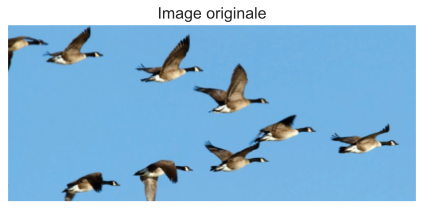

In [5]:
fig, ax = plt.subplots()

ax.imshow(rgb)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
ax.set_title('Image originale', fontsize=16)
plt.tight_layout()
plt.show()


# Partie II: Génération de la matrice $X=[R, G, B]$

#### Génération de la matrice des observations

Dans une image couleur de type RGB (*Red, Green, Blue*), un triplet d'intensités [rouge, vert, bleu] est associé à chaque pixel. C'est le mélange des trois intensités lumineuses qui génère la couleur d'un pixel donné.

L'image RGB est une matrice 3-D; les deux premières dimensions indiquent le nombre de pixels en y et en x. La troisième dimension indique le nombre de canaux. Il y en a trois; R, G et B. 

On transforme l'image en une matrice 2-D, ou chaque colonne est un canal de couleur (une caractéristique) et chaque ligne est un pixel (une observation).

In [6]:
# Séparation des canaux de couleurs
r = rgb[:,:,0].reshape(-1, 1)
g = rgb[:,:,1].reshape(-1, 1)
b = rgb[:,:,2].reshape(-1, 1)

X = np.concatenate((r, g, b), axis=1)

#### Normalisation des données

In [7]:
scaler = StandardScaler()
X_s = scaler.fit_transform(X)

## Partie III: Détermination du nombre optimal de couleurs avec la méthode k-moyennes

La méthode k-moyennes (*k-Means*) est la plus utilisée pour estimer le nombre de groupes dans un nuage de données multidimensionnel. Elle fait l'hypothèse que tous les groupes sont isotropes et ont la même dispersion spatiale. Bien que ce soit rarement le cas, le nombre de groupes estimé est souvent près de la réalité.

On utilise la métrique statistique de la [silhouette](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) pour évaluer la qualité des regroupements. Cette mesure est comprise entre [-1, 1].

Une bonne séparation d'un nuage de points en de multiples groupes compacts produit une valeur de silhouette près de 1.

#### Sélection d'un nombre réduit d'échantillons de la matrice des observations afin d'accélérer les calculs.  


In [8]:
# Nombre total d'observations
N = X_s.shape[0]

# Nombre d'échantillons à utiliser
Npts = 5000

indx = random.sample(range(0, N), Npts)
x_s = X_s[indx,:]

#### Calcul de la métrique de regroupement pour différents nombres de groupes

In [9]:
silhouette = [] 
for k in range(2, 11):
    # Regroupement des données en k groupes
    estimator = KMeans(n_clusters=k, n_init=10) 
    estimator.fit(x_s)
            
    # Calcul de la métrique pour ce regroupement
    silhouette.append(silhouette_score(x_s, estimator.labels_, metric='euclidean'))

#### Affichage des résultats

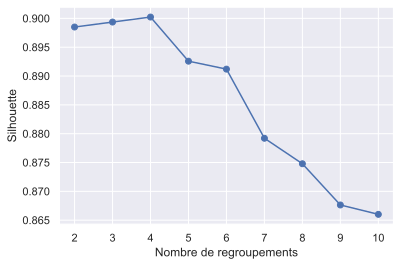

In [10]:
ngroupes = range(2, 11)

fig, ax = plt.subplots(1, 1, sharex=True, figsize = (6, 4)) 
ax.plot(ngroupes, silhouette, 'o-')
ax.set_xlabel('Nombre de regroupements');
ax.set_ylabel('Silhouette');

Le nombre optimal de groupes est de 4. La valeur correspondante de la métrique est très près de 1; la séparation des couleurs devrait être assez bonne.


# Partie IV: Génération d'images avec un nombre réduit de couleurs

#### Définissons une fonction pour comparer les résultats avec différents nombres de groupes/couleurs.

Pour un nombre de groupes donné, on peut utiliser la méthode des mélanges gaussiens (*Gaussian mixtures*) pour 
regrouper les données. Contrairement à la méthode des k-moyennes, elle fait l'hypothèse que tous les groupes sont différents entre eux et sont anisotropes; c'est souvent le cas en pratique.

In [11]:
def reduction_des_couleurs(X, rgb, n, ax=None):
    
    # Regroupement des données en n groupes
    gm = GaussianMixture(n_components=n, random_state=0, covariance_type='tied').fit(X)

    # Étiquettes des pixels
    y = gm.predict(X)
    y = y.reshape((rgb.shape[0], rgb.shape[1]))

    # Calcul de la valeur moyenne des canaux R, G et B pour chaque groupe
    couleurs_moyennes = np.zeros((n, 3))
    for k in range(n):
        x = rgb[y==k]
        couleurs_moyennes[k,:] = np.mean(x, axis=0)
    
    # Génération d'une carte de couleurs utilisant la couleur moyenne de chaque groupe
    cm_bright = ListedColormap(couleurs_moyennes)

    # Affichage de l'image des M&M avec n couleurs
    if ax is None:
        ax = plt.gca()

    ax.imshow(y, cmap=cm_bright)
    ax.set_title('K= %d' % (n), fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

## Affichage du meilleur résultat de réduction des couleurs

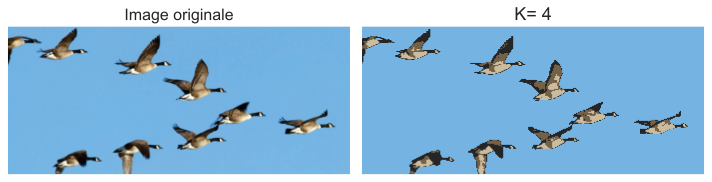

In [12]:
fig, axs = plt.subplots(1, 2, figsize = (10, 6)) 

axs[0].imshow(rgb)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].grid(False)
axs[0].set_title('Image originale', fontsize=16)

reduction_des_couleurs(X_s, rgb, 4, ax=axs[1])
plt.tight_layout()
plt.show()

La figure montre une bonne séparation des couleurs.